In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pywt
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, BatchNormalization,Dropout,LSTM,Dense,Activation,Flatten


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Epileptic Seizure Recognition.csv')

**Dataset**

In [ ]:
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [ ]:
data.drop('Unnamed', axis=1, inplace=True)

In [ ]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [ ]:
class_relabeling = {1:1, 2:0, 3:0, 4:0, 5:0}
data.replace({'y': class_relabeling}, inplace=True)

In [ ]:
counts = data['y'].value_counts()
print(f"Number of records epileptic {counts[1]} vs non-epileptic {counts[0]}")

Number of records epileptic 2300 vs non-epileptic 9200


In [ ]:
data_unpivoted = (data
                  .melt(id_vars=['y'], var_name='time_label', value_name='eeg', ignore_index=False)
                  .reset_index()
                  .rename(columns={'index': 'sample_index'})
                  )

data_unpivoted['time_index'] = (data_unpivoted['time_label']
                                .str.extract(r'(\d+)', expand=False)
                                .astype(int)
                                )

data_unpivoted = (data_unpivoted
                  .sort_values(by=['sample_index', 'time_index'])
                  .reindex(['sample_index', 'time_index', 'eeg', 'y'], axis=1)
                  )

**Crisp Datset for Statistical Analysis**

In [ ]:
data_unpivoted

,sample_index,time_index,eeg,y
0,0,1,135,0
11500,0,2,190,0
23000,0,3,229,0
34500,0,4,223,0
46000,0,5,192,0
...,...,...,...,...
2000999,11499,174,5,0
2012499,11499,175,4,0
2023999,11499,176,-2,0
2035499,11499,177,2,0


In [ ]:
n = 7

index_n_epileptic = data_unpivoted[data_unpivoted['y'] == 1]["sample_index"].unique()[:n]
index_n_nonepileptic = data_unpivoted[data_unpivoted['y'] == 0]["sample_index"].unique()[:n]

samples_to_show = np.concatenate((index_n_epileptic, index_n_nonepileptic))

<ipython-input-12-7b75ff2ed8df>:1: UserWarning: 
The palette list has fewer values (10) than needed (14) and will cycle, which may produce an uninterpretable plot.
  g = sns.relplot(


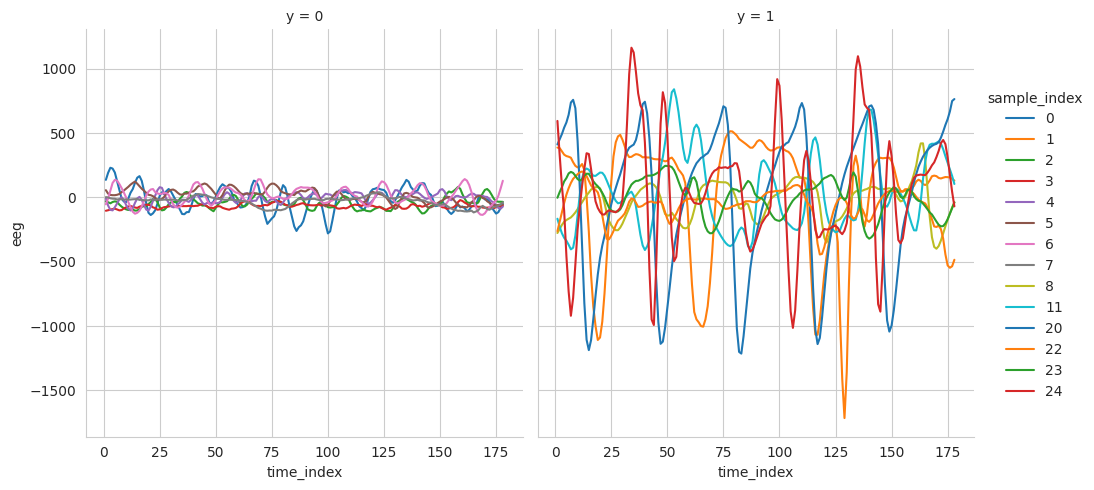

In [ ]:
g = sns.relplot(
    data=data_unpivoted[data_unpivoted["sample_index"].isin(samples_to_show)],
    kind='line',
    x='time_index',
    y='eeg',
    col='y',
    hue='sample_index',
    legend='full',
    palette=sns.color_palette()
)

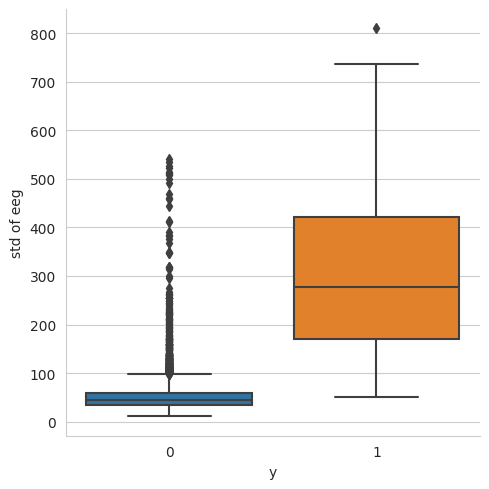

In [ ]:
g = sns.catplot(
    data=data_unpivoted.groupby(["sample_index", "y"]).std().reset_index(),
    kind='box',
    x='y',
    y='eeg',
)
g.set_ylabels("std of eeg")

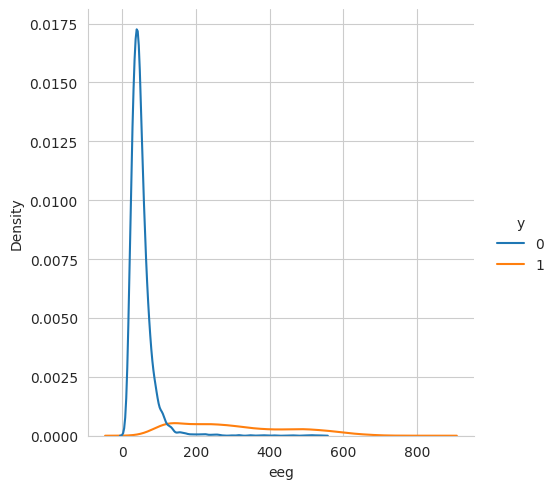

In [ ]:
sns.displot(
    data=data_unpivoted.groupby(["sample_index", "y"]).std().reset_index(),
    kind='kde',
    x='eeg',
    hue='y'
)

In [ ]:
data_unpivoted.describe()

,sample_index,time_index,eeg,y
count,2.047000e+06,2.047000e+06,2.047000e+06,2047000.0
mean,5.749500e+03,8.950000e+01,-7.722436e+00,0.2
std,3.319765e+03,5.138338e+01,1.645881e+02,0.4
min,0.000000e+00,1.000000e+00,-1.885000e+03,0.0
25%,2.874750e+03,4.500000e+01,-5.300000e+01,0.0
50%,5.749500e+03,8.950000e+01,-7.000000e+00,0.0
75%,8.624250e+03,1.340000e+02,3.600000e+01,0.0
max,1.149900e+04,1.780000e+02,2.047000e+03,1.0


In [ ]:
Y = data.iloc[:,178].values
Y.shape
Y[Y>1]=0
Y



array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
X = data.iloc[:,0:178].values
X

array([[ 135,  190,  229, ..., -116,  -83,  -51],
       [ 386,  382,  356, ...,  154,  143,  129],
       [ -32,  -39,  -47, ...,  -35,  -35,  -36],
       ...,
       [  14,    6,  -13, ...,   -2,   -1,   -8],
       [ -40,  -25,   -9, ...,   68,   59,   55],
       [  29,   41,   57, ...,   -2,    2,   20]])

**Feature Extraction : Discrete Wavelet Transform**

In [ ]:
def apply_dwt(x):
    coeffs = pywt.wavedec(x, 'db4', level=4)
    return np.concatenate(coeffs)

X_dwt = np.apply_along_axis(apply_dwt, axis=1, arr=X)

***Train-Test split ***

In [ ]:
X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(X_dwt, Y, test_size=0.4, random_state=42)


X_val, X_test_dwt, y_val, y_test = train_test_split(X_test_dwt,y_test,test_size=0.5,random_state=42)


In [ ]:
X_train_dwt.shape


(6900, 203)

**ALGORITHM: SVM**

In [ ]:
from sklearn.svm import SVC

clf_S = SVC()
clf_S.fit(X_train_dwt, y_train)
y_pred = clf_S.predict(X_val)
Svm_accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", Svm_accuracy*100)

# Calculate precision
precision = precision_score(y_val, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_val, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_val, y_pred)
print("F1-Score:", f1)

# Calculate and display the confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy: 96.08695652173913
Precision: 0.9414519906323185
Recall: 0.860813704496788
F1-Score: 0.8993288590604026
Confusion Matrix:
[[1808   25]
 [  65  402]]


**ALGORITHM: Naive Bayes**

In [ ]:
clf_N = GaussianNB()
clf_N.fit(X_train_dwt, y_train)
y_pred = clf_N.predict(X_val)
NV_accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", NV_accuracy*100)

# Calculate precision
precision = precision_score(y_val, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_val, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_val, y_pred)
print("F1-Score:", f1)

# Calculate and display the confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy: 94.3913043478261
Precision: 0.868995633187773
Recall: 0.8522483940042827
F1-Score: 0.8605405405405405
Confusion Matrix:
[[1773   60]
 [  69  398]]


**Algorithm: ANN**

In [ ]:
from tensorflow.keras import callbacks

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#now we will going to scale the dataset
X_train = scaler.fit_transform(X_train_dwt)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test_dwt)

In [ ]:
X_train.shape

(6900, 203)

**Model Building**

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

model = Sequential()

#layers
model.add(Dense(units=32,kernel_initializer='uniform',activation='relu',input_dim=203))

model.add(Dense(units=64,kernel_initializer='uniform',activation='relu'))
model.add(Dense(units=32,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=32,kernel_initializer='uniform',activation='relu'))
model.add(Dense(units=16,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,kernel_initializer='uniform',activation='relu'))

#finding out the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                6528      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model_train = model.fit(X_train,y_train,batch_size=32,epochs=500,callbacks=[early_stopping],validation_split=0.2)

Epoch 1/500
173/173 [==============================] - 3s 4ms/step - loss: 0.4719 - accuracy: 0.8703 - val_loss: 0.1830 - val_accuracy: 0.9232
Epoch 2/500
173/173 [==============================] - 0s 3ms/step - loss: 0.2010 - accuracy: 0.9371 - val_loss: 0.1713 - val_accuracy: 0.9428
Epoch 3/500
173/173 [==============================] - 0s 3ms/step - loss: 0.1830 - accuracy: 0.9527 - val_loss: 0.1662 - val_accuracy: 0.9514
Epoch 4/500
173/173 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.9558 - val_loss: 0.1539 - val_accuracy: 0.9522
Epoch 5/500
173/173 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9491 - val_loss: 0.1811 - val_accuracy: 0.9500
Epoch 6/500
173/173 [==============================] - 0s 2ms/step - loss: 0.1474 - accuracy: 0.9609 - val_loss: 0.2324 - val_accuracy: 0.9565
Epoch 7/500
173/173 [==============================] - 1s 3ms/step - loss: 0.1578 - accuracy: 0.9676 - val_loss: 0.2218 - val_accuracy: 0.9558

In [ ]:
predictions = model.predict(X_val)
pred_labels =np.round(predictions)
Ann_accuracy = accuracy_score(y_val,pred_labels)

print("Accuracy:", Ann_accuracy*100)

72/72 [==============================] - 0s 2ms/step
Accuracy: 82.1304347826087


**Algorithm : KNN**

In [ ]:
X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(X_dwt, Y, test_size=0.4, random_state=42)

#now we will be dividing it into further to get the validation set
X_val, X_test_dwt, y_val, y_test = train_test_split(X_test_dwt,y_test,test_size=0.5,random_state=42)

In [ ]:
clf_k =  KNeighborsClassifier(n_neighbors= 100)
clf_k.fit(X_train_dwt, y_train)
y_pred = clf_k.predict(X_val)
Knn_accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", Knn_accuracy*100)

# Calculate precision
precision = precision_score(y_val, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_val, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_val, y_pred)
print("F1-Score:", f1)

# confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy: 83.0
Precision: 0.975
Recall: 0.1670235546038544
F1-Score: 0.28519195612431447
Confusion Matrix:
[[1831    2]
 [ 389   78]]


**Comparision Table of Accuracy**

In [ ]:
table = [
    ['Naive B', NV_accuracy*100],
    ['k-Nearest Neighbors', Knn_accuracy*100],
    ['Support Vector Machines', Svm_accuracy*100],
    ['Artificial Neural Networks', Ann_accuracy*100]
]

# Print the comparison table
table.sort(key=lambda x: x[1], reverse=True)

print('| Algorithm                    | Accuracy (%) |')
print('|------------------------------|-----------|')
for row in table:
    print(f'| {row[0]:30} | {row[1]:.4f}    |')

| Algorithm                    | Accuracy (%) |
|------------------------------|-----------|
| Support Vector Machines        | 96.0870    |
| Naive B                        | 94.3913    |
| k-Nearest Neighbors            | 83.0000    |
| Artificial Neural Networks     | 82.1304    |


**MODEL SELECTION AND PREDICTION FOR UNSEEN DATA**

In [ ]:
print("SVM")
y_pred = clf_S.predict(X_test_dwt)

precision = accuracy_score(y_pred,y_test)* 100

print("Accuracy of the model by using the SVM algorithm : {0:.2f}%".format(precision))

SVM
Accuracy of the model by using the SVM algorithm : 96.83%
